### This is PyTorch implementaion of the experiment described in the paper [The Mechanics of n-Player Differentiable Games](https://arxiv.org/abs/1802.05642)

The main goal of the following experiment is to answer the following questions regarding Symplectic Gradient Adjustment:

 - 1) Will it reduce mode collapse?
 - 2) Does it accelerate learning process and improve generator quality?

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import urllib
import requests
from IPython.core.display import clear_output

from os import path
# нужна информация о нашей системе
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

# уточним на чем будем вычислять
accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
import torchvision
print('torch version',torch.__version__)
print('torchvision version',torchvision.__version__)
print('is cuda availible',torch.cuda.is_available())

tcmalloc: large alloc 1073750016 bytes == 0x5b776000 @  0x7fa1b104d2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
torch version 0.4.0
torchvision version 0.2.1
is cuda availible True


# 1. Without SGA

We will use just a simple GAN

In [0]:
from torch import nn

class MLP(nn.Module):
  
  def __init__(self, latent_dim, output_dim):
    
    super(MLP, self).__init__()
    
    self.latent_dim = latent_dim
    self.output_dim = output_dim
    self.hidden_dim = 384
    
    self.main = nn.Sequential(
                nn.Linear(self.latent_dim, self.hidden_dim),
                nn.ReLU(True),
                nn.Linear(self.hidden_dim, self.hidden_dim),
                nn.ReLU(True),
                nn.Linear(self.hidden_dim, self.output_dim))
                nn.ReLU(True),
                nn.Linear(self.hidden_dim, self.hidden_dim),
                nn.ReLU(True),
                nn.Linear(self.hidden_dim, self.hidden_dim),
                nn.ReLU(True),
                nn.Linear(self.hidden_dim, self.hidden_dim),
                nn.ReLU(True),
                nn.Linear(self.hidden_dim, self.output_dim))

  def forward(self, inp):

      return self.main(inp)



In [0]:
def x_real_builder(batch_size):
    sigma = 0.1
    skel = np.array([
        [ 1.50,  1.50],
        [ 1.50,  0.50],
        [ 1.50, -0.50],
        [ 1.50, -1.50],
        [ 0.50,  1.50],
        [ 0.50,  0.50],
        [ 0.50, -0.50],
        [ 0.50, -1.50],
        [-1.50,  1.50],
        [-1.50,  0.50],
        [-1.50, -0.50],
        [-1.50, -1.50],
        [-0.50,  1.50],
        [-0.50,  0.50],
        [-0.50, -0.50],
        [-0.50, -1.50],
    ])
    
    temp = np.tile(skel, (batch_size // 16 + 1,1))
    mus = torch.FloatTensor(temp[0:batch_size,:])
    return torch.FloatTensor(mus + sigma*torch.randn([batch_size, 2]))

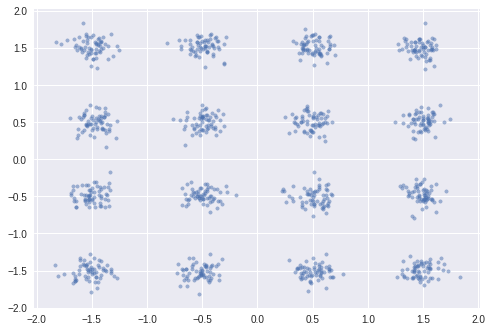

In [6]:
x = x_real_builder(1000)

plt.scatter(x[:,0], x[:,1], marker = '.', alpha = 0.5)

## Now let's apply the original algorithm from [here](https://arxiv.org/abs/1406.2661) 

![](https://cdn-images-1.medium.com/max/800/1*WnsJz9ZKS3dV3Nw36RtefQ.png)

100%|██████████| 10000/10000 [02:52<00:00, 58.00it/s]


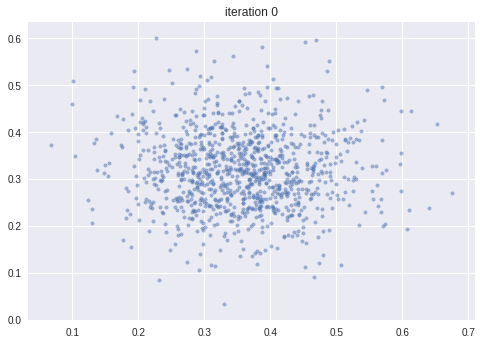

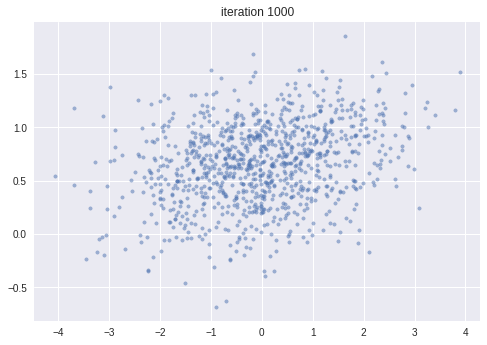

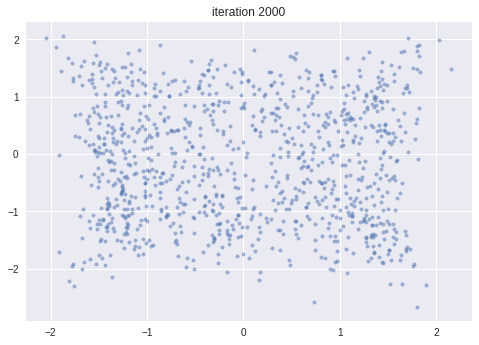

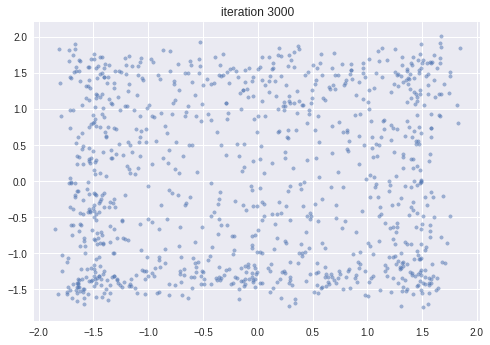

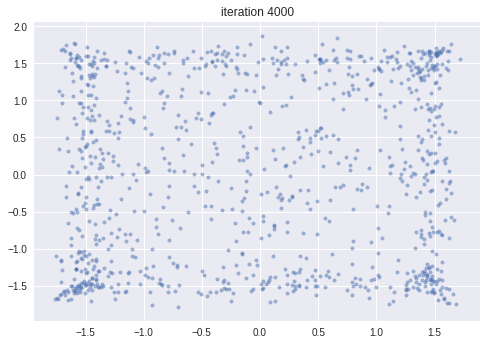

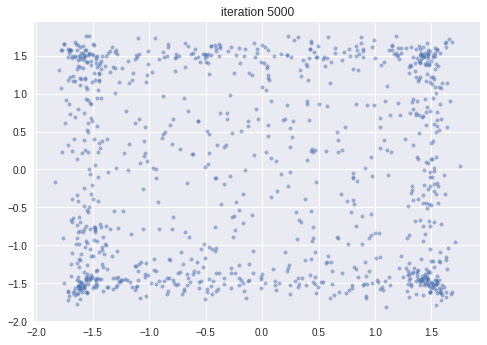

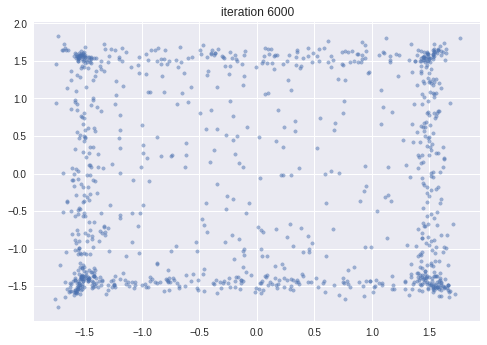

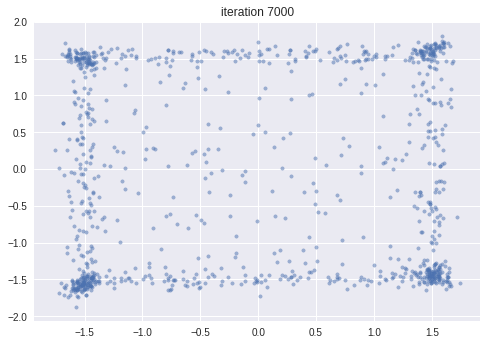

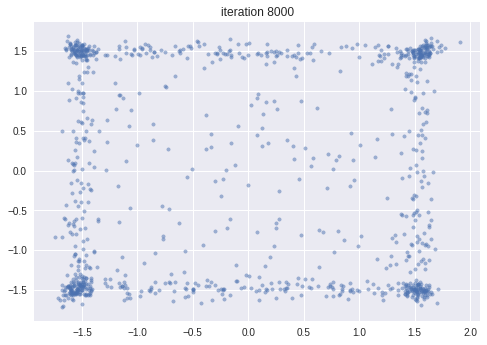

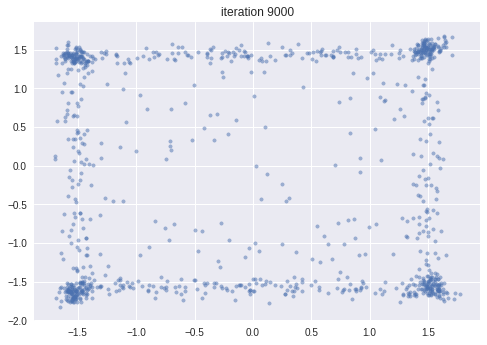

In [29]:
z_dim = 64

generator = MLP(z_dim, 2).cuda()
discriminator = MLP(2,1).cuda()

n_iter = int(1e+4)
batch_size = 256

disc_loss_hist = []
gen_loss_hist = []

optimizer_G = torch.optim.RMSprop(generator.parameters(), lr = 1e-4)
optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr = 1e-4)

loss = nn.BCEWithLogitsLoss()

k = 1

plot_freq = 1e+3

for it in tqdm(range(n_iter)):
  
  for i in range(k):
    
    discriminator.zero_grad()

    z = torch.randn([batch_size, z_dim]).cuda()
    x_fake = generator(z)
    x_real = x_real_builder(batch_size).cuda()
    disc_out_real = discriminator(x_real)
    disc_out_fake = discriminator(x_fake)

    # Loss
    disc_loss_real = loss(disc_out_real, torch.ones_like(disc_out_real).cuda())
    disc_loss_fake = loss(disc_out_fake, torch.zeros_like(disc_out_fake).cuda())

    disc_loss = disc_loss_real + disc_loss_fake
    disc_loss_hist += [disc_loss]

    disc_loss.backward()
    optimizer_D.step()
    
  generator.zero_grad() 
  
  z = torch.randn([batch_size, z_dim]).cuda()
  x_fake = generator(z)
  disc_out_fake = discriminator(x_fake)

  gen_loss = loss(disc_out_fake, torch.ones_like(disc_out_fake).cuda())
  gen_loss_hist += [gen_loss]
  
  gen_loss.backward()
  optimizer_G.step()
  
  if it%plot_freq == 0:
    
    n = 1000

    z = torch.randn([n, z_dim]).cuda()
    x_fake = generator(z).cpu().detach().numpy()

    plt.figure()
    plt.scatter(x_fake[:,0], x_fake[:,1], marker = '.', alpha = 0.5)
    plt.title('iteration {}'.format(it))
    plt.plot()



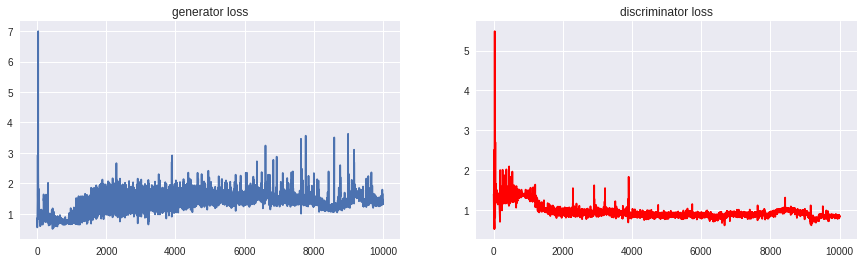

In [24]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize = (15,4))

ax1.plot(gen_loss_hist)
ax1.set_title('generator loss')
ax2.plot(disc_loss_hist, 'r')
ax2.set_title('discriminator loss')

plt.show()

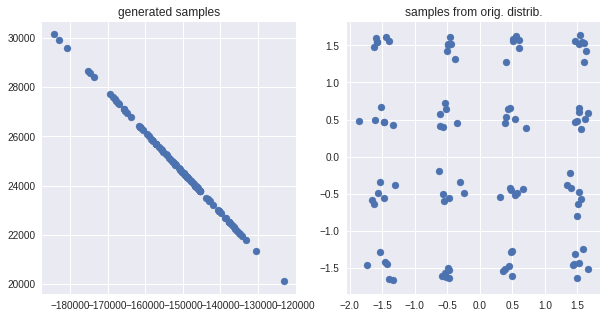

In [22]:
n = 100

z = torch.randn([n, z_dim]).cuda()
x_fake = generator(z).cpu().detach().numpy()
x_real = x_real_builder(n)

fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize = (10,5))

ax1.scatter(x_fake[:,0], x_fake[:,1])
ax1.set_title('generated samples')
ax2.scatter(x_real[:,0], x_real[:,1])
ax2.set_title('samples from orig. distrib.')

plt.show()


# 1. With SGA

We will use just a simple GAN but with SGA binded with optimizer

Here is an algorithm of SGA from the paper:

% $  $

![](https://cdn-ak.f.st-hatena.com/images/fotolife/t/toaruharunohi/20180926/20180926224437.png)